# Boosting de Algoritmos

> - Aplicar 2 boosting como mínimo.
> - En conclusión, comparar con los otros modelos anteriores.

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Encoding | Codificación
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# To save models
import json
import pickle
# Feature Selection
from sklearn.feature_selection import f_classif, SelectKBest
# Modelado
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, mean_absolute_percentage_error, root_mean_squared_error, r2_score
# Optimizar
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from tqdm import tqdm
import warnings
from utils import get_regression_metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from pickle import dump
from sklearn.tree import DecisionTreeRegressor
from utils import get_classifier_metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



In [142]:
df_ini = pd.read_csv('../data/processed/df_ini_insulina.csv')



## Split

In [143]:
# Dividimos el conjunto de datos en muestras de train y test
X = df_ini.drop('Outcome', axis=1)
y = df_ini['Outcome']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

In [144]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [145]:
y.unique()

array([1, 0])

## Modelado.

In [146]:
xgb = XGBClassifier(n_estimators=200,
                    learning_rate=0.1,
                    random_state=18,
                    use_label_encoder=False,
                    eval_metric='mlogloss')
ada = AdaBoostClassifier(n_estimators=200,
                         learning_rate=0.1,
                         random_state=18)

## Entrenamiento

In [147]:
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [148]:
ada.fit(X_train, y_train)

,estimator,None
,n_estimators,200
,learning_rate,0.1
,algorithm,'deprecated'
,random_state,18


In [149]:
# predicción
ada_y_pred_test = ada.predict(X_test)
xgb_y_pred_test = xgb.predict(X_test)


ada_y_pred_train = ada.predict(X_train)
xgb_y_pred_train = xgb.predict(X_train)


In [150]:
accuracy_train = (accuracy_score(y_train, ada_y_pred_train),
                  accuracy_score(y_train, xgb_y_pred_train))
accuracy_test = (accuracy_score(y_test, ada_y_pred_test),
                 accuracy_score(y_test, xgb_y_pred_test))

accuracy = pd.DataFrame(data=[accuracy_train, accuracy_test],
                        columns=['AdaBoost', 'XGBoost'],
                        index=['Train set', 'Test set'])

accuracy

,AdaBoost,XGBoost
Train set,0.788274,1.000000
Test set,0.740260,0.714286


> ### 1º Conclusión:
> Nuestro modelo actualmente tiene un 74% de acierto con el modelo de Ada, 71% con XBGBoost.
>
> Voy a Hiperparametrizar el XBG para ver si mejoro los resultados ya que ese 100% está sobre entrenandome el modelo.

### Hiperparametrización de XGB

In [ ]:
# Definir hiperparámetros a probar
xgb_y_pred_test = {'n_estimators':[20, 30, 40],
                   'max_depth': [1, 2, 5],
                   'gamma':[0.5, 0.75, 1, 2, 5],
                   'min_child_weight': [1, 2, 3],
                   'max_delta_step': [1, 2, 4],
                   'subsample':[0.1, 0.2, 0.5, 0.75]}

# Implementar GridSearchCV
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=18),
                                xgb_y_pred_test,
                                cv=5,
                                n_jobs=-1,
                                verbose=1)

# Entrenamos
grid_search_xgb.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
grid_search_xgb.best_params_

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


{'gamma': 1,
 'max_delta_step': 2,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 30,
 'subsample': 0.5}

### Best Estimator

In [177]:
# Mejor modelo
grid_search_xgb.best_estimator_

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [178]:
# Entrenamos
grid_search_xgb.best_estimator_.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [179]:
y_pred_test_grid = grid_search_xgb.best_estimator_.predict(X_test)
y_pred_train_grid = grid_search_xgb.best_estimator_.predict(X_train)


In [ ]:
# Métricas del Boosting de Algoritmos.

get_classifier_metrics(y_pred_test_grid, y_test, y_pred_train_grid, y_train)

,Accuracy,F1 Score,Precision,Recall
Train set,0.837134,0.837134,0.837134,0.837134
Test set,0.733766,0.733766,0.733766,0.733766


In [156]:
with open('../models/Boosting-xgb-insulina.pkl', 'wb') as file:
    pickle.dump(xgb, file)

with open('../models/Boosting-ada-insulina.pkl', 'wb') as file:
    pickle.dump(ada, file)

with open('../models/Boosting-gb-insulina.pkl', 'wb') as file:
    pickle.dump(gb, file)



### Resultados de árbol de decisión.
>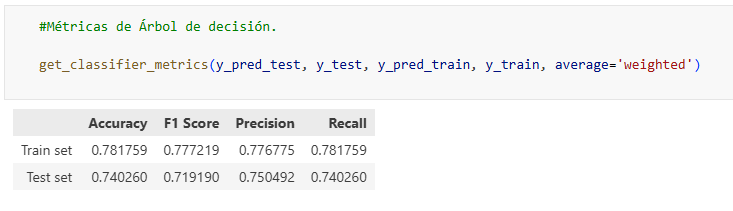

### Resultados de Random Forest
> 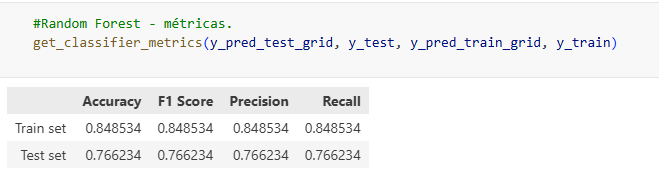

> ### Conslusión:
> - Con Ada, he conseguido un 74% de acierto frente un 79% en train.
> - Por mucho que hiperparametrizo XGB no consigo bajar del 83 vs 73% en test.
> - Haciendo un random forest por clasificación he conseguido un modelo con un 76% de acierto.
> - Con el modelo de Árbol de decisión he conseguido un 74% de acierto frente a un 78% en train.
>
>Por lo que podríamos decir que el mejor modelo para esta base de datos sería un Árbol de decisión ya que es el que menos % tiene entre Train y Test. 